# Imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import numba
from numba import njit
from scipy.ndimage import convolve
import imageio
from pathlib import Path

# Function definition

In [3]:
def get_energy(lattice, N, J1, J2):
    kernel_nn = np.array([
                [0, 1, 0],
                [1, 0, 1],
                [0, 1, 0]])
    
    kernel_nnn = np.array([
                [1, 0, 1],
                [0, 0, 0],
                [1, 0, 1]])
    
    energy_nn = -J1 * lattice * convolve(lattice, kernel_nn, mode='wrap')
    energy_nnn = -J2 * lattice * convolve(lattice, kernel_nnn, mode='wrap')
    
    return (energy_nn + energy_nnn).sum()/(2*N)

In [4]:
@njit
def get_dE(lattice, x, y, N, J1, J2):
    nn_sum = (
        lattice[(x-1)%N, y] + lattice[(x+1)%N, y] +
        lattice[x, (y-1)%N] + lattice[x, (y+1)%N]
    )

    nnn_sum = (
        lattice[(x-1)%N, (y-1)%N] + lattice[(x+1)%N, (y-1)%N] +
        lattice[(x-1)%N, (y+1)%N] + lattice[(x+1)%N, (y+1)%N]
    )

    dE = 2 * lattice[x, y] * (J1 * nn_sum + J2 * nnn_sum)

    return dE

In [ ]:
@njit
def metropolis(lattice, MC_steps, T, energy, N, J1, J2, save_images=False, image_spacing=None, verbose=0):

    # 1. Initialize variables
    web = lattice.copy()
    net_spins = np.zeros(MC_steps)
    net_energy = np.zeros(MC_steps)

    # Information output. Ammount if information printed is controlled by verbose.
    if verbose > 0:
        print(f"Starting simulation with configuration:")
        print(f"\t - NxN: {N}x{N}")
        print(f"\t - Temperature: {T}")
        print(f"\t - J1: {J1}")
        print(f"\t - J2: {J2}")
        print(f"\t - MC steps: {MC_steps}")
    if verbose > 1:
        print(f"\t - Initial energy: {energy}")
        print(f"\t - Initial magnetization: {web.sum()/(N**2)}")

    #------------------------
    #   Image saving logic
    #------------------------
    if save_images and image_spacing is not None:
        if verbose > 0:
            print(f"This run wil save {len(image_spacing)} images")
        images = np.empty((len(image_spacing), N, N), dtype=np.int8)
        aux_img_idx = 0
    # 'None' used for consistency in the return statement
    else:
        if verbose > 0:
            print(f"This run will not save images")
        images = None

    # ---------------------
    #       Main loop
    # ---------------------
    for t in range(MC_steps):
        if save_images and t in image_spacing:
            if verbose > 1:
                print(f"Saving state at step: {t}/{MC_steps}")
            images[aux_img_idx] = web.copy()
            aux_img_idx += 1

        # 2. Choose a random spin to evaluate
        x = np.random.randint(0, N)
        y = np.random.randint(0, N)


        # 3. Compute the change in energy
        dE = get_dE(web, x, y, N, J1, J2)

        # 4. Apply flipping condition
        if ((dE > 0) * (np.random.random() < np.exp(-dE/T))):
            web[x,y] *= -1
            energy += dE
        elif dE<=0:
            web[x,y] *= -1
            energy += dE
            
        # 5. Save net spin (magnetization) and energy
        net_spins[t] = web.sum()/(N**2)
        net_energy[t] = energy

    # 
    if save_images and image_spacing is not None:
        images[-1] = web.copy()

            
    return net_spins, net_energy, images

In [6]:
def path_configuration(N, T, J1=None, J2=None, data_dir='data', figures_dir='figures', verbose=0):
    """
    Create the directory structure for the simulation data and figures.
    """
    if verbose > 0:
        print(f"Creating directory structure for N={N}, T={T}")
    
    # Parent folder
    if verbose > 1:
        print(f"Creating parent folder")
    if J1 is None or J2 is None:
        parent_name = f"Simulation_N{N}_T{T}"
    else:
        parent_name = f"Simulation_N{N}_T{T}_J1{J1}_J2{J2}"
    parent_dir = Path(parent_name)
    parent_dir.mkdir(parents=True, exist_ok=True)

    # Sub folders
    data_dir = parent_dir / data_dir
    figures_dir = parent_dir / figures_dir
    if verbose > 1:
        print(f"Creating data folder")
        print(f"Creating figures folder")
    data_dir.mkdir(parents=True, exist_ok=True)
    figures_dir.mkdir(parents=True, exist_ok=True)

# Simulation parameters

In [12]:
SEED = 42
np.random.seed(SEED)

N = 100
J1 = 0.5
J2 = 1.0
T = 0.5
MC_steps = 10000000

In [8]:
# Generate a random 2D lattice

# Probability of value 1 [-1 has (p-1) probability]
p_1 = 0.5
lattice = np.random.choice([1, -1], size=(N, N), p=[p_1, 1-p_1])

In [9]:
# Get initial energy of the lattice
energy = get_energy(lattice, N, J1, J2)

# Desired number of states to save
n_images = 50

# Generate the appropriate spacing for the images
# Using logspace to get more images at the early stages (more change) and less at the end (less change)
img_spacing = set(np.logspace(0, np.log10(MC_steps), num=n_images, endpoint=True, dtype=int))

In [13]:
simulation_params = {
    'lattice' : lattice,
    'MC_steps' : MC_steps,
    'T' : T,
    'energy' : energy,
    'N' : N,
    'J1' : J1,
    'J2' : J2,
    'save_images' : True,
    'image_spacing' : img_spacing,
    'verbose' : 0
    }

# Run the Metropolis algorithm
spins, energies, images, image_indices = metropolis(**simulation_params)

In [206]:
def create_gif(images, filename="simulation.gif", fps=10, scale=1, cmap="gray", verbose=True):
    """
    Create a GIF from a list of 2D numpy arrays.

    Parameters:
    - images: list of 2D numpy arrays (values in -1 or 1)
    - filename: output GIF filename
    - fps: frames per second
    - scale: scaling factor for image size (integer)
    - cmap: matplotlib colormap name (e.g., 'gray', 'viridis', 'plasma', etc.)
    """
    duration = len(images) / fps

    # Create writer
    with imageio.get_writer(filename, mode="I", duration=duration / len(images)) as writer:
        for img in images:
            # Normalize lattice values to 0-255
            norm_img = ((img + 1) * 127.5).astype(np.uint8)

            # Apply colormap if not grayscale
            if cmap != "gray":
                colored_img = plt.get_cmap(cmap)(norm_img / 255.0)  # RGBA values 0-1
                colored_img = (colored_img[:, :, :3] * 255).astype(np.uint8)  # Drop alpha
            else:
                colored_img = np.stack([norm_img]*3, axis=-1)  # Grayscale to RGB

            # Scale image if needed
            if scale > 1:
                colored_img = colored_img.repeat(scale, axis=0).repeat(scale, axis=1)

            # Write frame
            writer.append_data(colored_img)
    if verbose:
        print(f"GIF saved as {filename}")


C:\Users\rbern\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


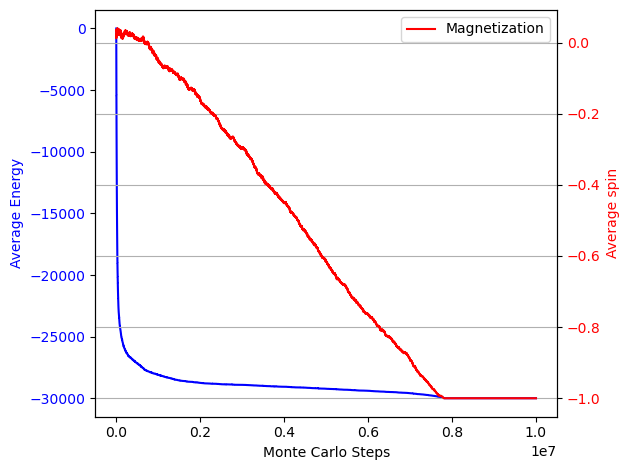

In [14]:
tolerance = 0.01

energy_color = "blue"
spin_color = "red"

fig, ax1 = plt.subplots()

ax1.set_xlabel("Monte Carlo Steps")
ax1.set_ylabel("Average Energy", color=energy_color)
ax1.plot(energies, color=energy_color, label="Energy")
ax1.tick_params(axis='y', labelcolor=energy_color)

# equilibrium_x = np.argmin(energies)
# ax1.axvline(x=equilibrium_x, color='gray', linestyle='--', label="Equilibrium")

ax2 = ax1.twinx()
ax2.set_ylabel("Average spin", color=spin_color)
ax2.plot(spins, color=spin_color, label="Magnetization")
ax2.tick_params(axis='y', labelcolor=spin_color)

fig.tight_layout()
plt.grid()
plt.legend()
plt.show()
plt.close()

In [207]:
create_gif(images, filename="simulation.gif", fps=10, scale=8, cmap="plasma", verbose=True)

GIF saved as simulation.gif
